In [ ]:
"""
    -- Description:
        
        This notebook applies meta-labeling method.
        
        (1) We train a primary model on original data, and a secondary model on meta data.
        
        (2) The primary model has a high recall rate for positive samples
        
        (3) The secondary model provides the probability for positive cases
        
        (4) By decoupling, we achieve a solution to predicting position side / size separately
        
            For example, the primary model can be replaced by PM's prediction, where in such cases 
        
            the betting size can be determined by ML models, as what Quantamental does.
        
    -- Auther:
        
        Fang Fan (Roy)
        
    -- Date:
        
        September 19, 2020
    
""";

In [2]:
import seaborn as sns
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils.testing import ignore_warnings

seed = 100

In [3]:
data = load_breast_cancer()
X = data["data"]
y = data["target"]

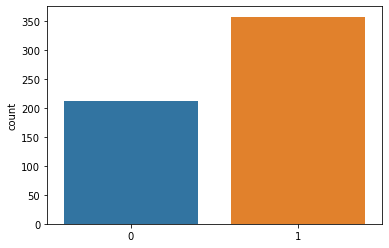

In [4]:
# Check Positive/Negative Numbers
sns.countplot(y);

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [6]:
print(X_train.shape[0], X_test.shape[0])

455 114


## Primary Model: Logistic Regression

In [11]:
# Basic Logistic Regression Model
@ignore_warnings(category=ConvergenceWarning)
def train_base_model(X_train, y_train):
    model_ = LogisticRegression()
    model_.fit(X_train, y_train)
    return model_

model_ = train_base_model(X_train, y_train)

In [12]:
# Set lower threshold for high recall rate on positive samples
thres = 0.2

In [13]:
# Primary Model
primary_model = lambda x: (model_.predict_proba(x)[:, 1] > thres).astype("int")

In [14]:
# Primary Model Prediction
primary_prediction_on_train = primary_model(X_train)

## Get Meta Features and Meta Labels

In [15]:
meta_features_on_train = np.hstack((primary_prediction_on_train.reshape(-1,1), X_train))

In [16]:
meta_labels_on_train = primary_prediction_on_train & y_train

## Secondary Model: Random Forest

In [17]:
secondary_model = RandomForestClassifier(max_depth=2, random_state=0)

In [18]:
# Secondary Model Training
secondary_model.fit(meta_features_on_train, meta_labels_on_train);

## Evaluate Performance on Test Set

In [19]:
# Primary Model Layer
primary_prediction_on_test = primary_model(X_test)

# Secondary Model Layer
meta_features_on_test = np.hstack((primary_prediction_on_test.reshape(-1,1), X_test))
secondary_prediction_on_test = secondary_model.predict(meta_features_on_test)

In [20]:
# Get Final Prediction Results
final_prediction_on_test = primary_prediction_on_test & secondary_prediction_on_test

In [21]:
# Meta Labeling Performance
print(classification_report(y_test, final_prediction_on_test))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        49
           1       0.95      0.95      0.95        65

    accuracy                           0.95       114
   macro avg       0.95      0.95      0.95       114
weighted avg       0.95      0.95      0.95       114



In [22]:
# Merely Primary Model Performance
print(classification_report(y_test, primary_prediction_on_test))

              precision    recall  f1-score   support

           0       0.96      0.88      0.91        49
           1       0.91      0.97      0.94        65

    accuracy                           0.93       114
   macro avg       0.93      0.92      0.93       114
weighted avg       0.93      0.93      0.93       114



## Probability from Secondary Model

In [23]:
prob_on_test = secondary_model.predict_proba(meta_features_on_test)[:, 1]

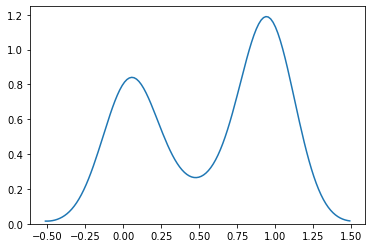

In [24]:
sns.kdeplot(prob_on_test);